In [1]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.utils import db_to_float 

In [2]:
default_rate = 44100
default_freq = 400  # Hz
default_length = 2  # sec
default_amp = 0.999

In [3]:
def numpy_to_audio_segment(audio_arr, amp=1.0, rate=default_rate, channels=1, sample_width=4):
    audio_arr = audio_arr / (abs(audio_arr).max())
    audio_arr_trans = ((2**(8*sample_width-1)-1) * amp * audio_arr).astype(np.int32)
    audio_segment = AudioSegment(audio_arr_trans.tobytes(),
                                 frame_rate=rate,
                                 sample_width=sample_width,
                                 channels=channels)
    return audio_segment

def audio_segment_to_numpy(seg, th=1.0):
    frame_rate = seg.frame_rate
    seg_arr = np.array(seg.get_array_of_samples())
    seg_arr = th * seg_arr / seg.max_possible_amplitude
    return seg_arr, frame_rate

# interactive plot

In [4]:
import librosa
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact

In [5]:
wav_path = '/home/sen/Music/2313_20sec.wav'

In [6]:
window_length = 0.3
t_sec = 15.2

freq_bins = [50, 200, 500, 1000, 4000, 8000, 12000]
# bins = [0, 40, 80, 150, 400, 1000, 4000]

In [7]:
def values_to_indices(values, arr):
    return np.array([(arr < v).sum() for v in values])

## modules

In [8]:
def load_wav(wav_path, sr=None, mono=True):
    audio_arr, sr = librosa.load(wav_path, sr=sr, mono=mono)
    return audio_arr, sr

def get_spectrogram(audio_arr, sr, window_length):
    
    window_n = int(sr * window_length)
    fq, t, fq_am = stft(audio_arr, nperseg=window_n, fs=sr)
    spec = abs(fq_am)
    
    return fq, t, spec

def plot_spectrogram(fq, spec_to_plot, scale='mel', log_y=False, ep=1e-25):
    
    if scale == 'mel':
        x = librosa.hz_to_mel(fq)
    elif scale == 'hz':
        x = fq
        
    if log_y:
        y = np.log(spec_to_plot + ep)
    else:
        y = spec_to_plot
        
    fig, ax = plt.subplots(figsize=(12,9))
    ax.plot(x, y)
    ax.set_xticks(x[bins])
    ax.set_xticklabels(fq[bins].astype(np.int))

def sec_to_index(t_sec, t):
    t_idx = (t < t_sec).sum()
    return t_idx

## plots

In [9]:
def process_wav(wav_path):
    audio_arr, sr = load_wav(wav_path)
    fq, t, spec = get_spectrogram(audio_arr, sr, window_length)
    return audio_arr, sr, fq, t, spec

In [10]:
audio_arr, sr, fq, t, spec = process_wav(wav_path)
bins = values_to_indices(freq_bins, fq)

In [11]:
log_y = False
scale = 'mel'

In [12]:
def plot_at_t(t_sec):
    spec_to_plot = spec[:, sec_to_index(t_sec, t)]
    plot_spectrogram(fq, spec_to_plot, log_y=log_y, scale=scale)
    return numpy_to_audio_segment(audio_arr[int(t_sec*sr):int(t_sec*sr+window_length*sr)])

In [13]:
interact(plot_at_t, t_sec=(t[0], t[-1], t[2]))

interactive(children=(FloatSlider(value=11.700000000000001, description='t_sec', max=23.55, step=0.30000000000…

<function __main__.plot_at_t(t_sec)>

## mel spec

In [14]:
from scipy.fftpack import dct, idct

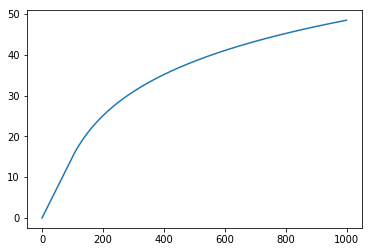

In [15]:
plt.plot(librosa.hz_to_mel(np.arange(0, 10000, 10)))

In [16]:
mel_mat = librosa.filters.mel(sr=sr, n_fft=int(window_length * sr))
f_mel = fq[mel_mat.argmax(axis=1)]

mel_spec = np.dot(mel_mat, spec)
mel_spec_sq = np.dot(mel_mat, spec**2)

In [17]:
t_sec = 3.3
t_idx = sec_to_index(t_sec, t)

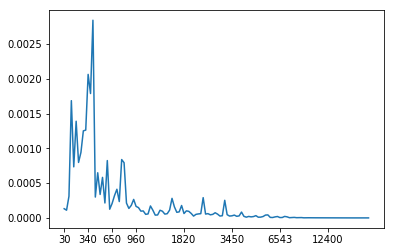

In [18]:
fig, ax = plt.subplots()
y = mel_spec[:,t_idx]
# y_ = mel_spec_piano_sq[:,t_index]
x = np.arange(y.shape[0])
bins = [0, 10, 20, 30, 50, 70, 90, 110]
ax.set_xticks(x[bins])
ax.set_xticklabels([int(f) for f in f_mel[bins]])
ax.plot(y)
# ax.plot(y_)
plt.savefig('mel_bank.png')

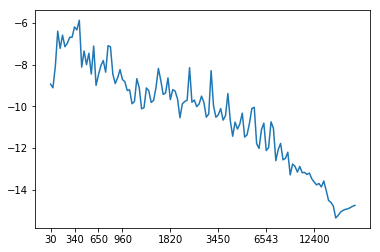

In [19]:
fig, ax = plt.subplots()
y = mel_spec[:,t_idx]
# y_ = mel_spec_piano_sq[:,t_index]
x = np.arange(y.shape[0])
bins = [0, 10, 20, 30, 50, 70, 90, 110]
ax.set_xticks(x[bins])
ax.set_xticklabels([int(f) for f in f_mel[bins]])
ax.plot(np.log(y))
# ax.plot(np.log(y_))
plt.savefig('mel_bank_log.png')

In [20]:
dct_mel = dct(np.log(y), norm='ortho')

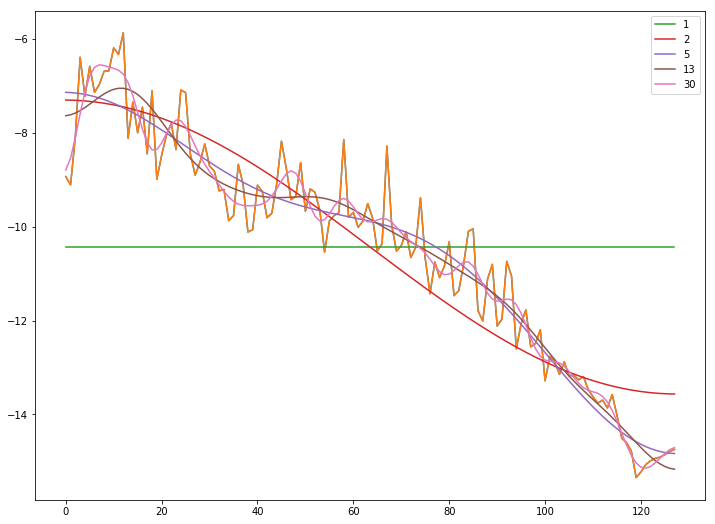

In [21]:
n_lst = [1,2,5,13, 30]
plt.figure(figsize=(12,9))
plt.plot(np.log(y))
plt.plot(idct(dct_mel, norm='ortho'))
for n in n_lst:
    mel_n = np.zeros_like(dct_mel)
    mel_n[:n] = dct_mel[:n]
    plt.plot(idct(mel_n, norm='ortho'), label=n)
plt.legend()

In [22]:
dct_mel[:10]

array([-1.18018354e+02,  2.50760551e+01, -4.40889870e+00,  5.73393360e+00,
       -1.24330728e-02,  9.66215952e-01, -1.14450042e+00, -1.14414059e+00,
       -1.09533243e+00, -3.21498282e-01])